# Temperature Visualization and Nusselt number calculation using SCR method.

**Here we analyse the temperature variation temporally (during drainage) and spatially (along channel).**

**We then fit a exponential law to study the temperature decrease along the channel (because of the energy used to melt the ice) and analyse the $e-folding$ length variation. We compute Figure 7.**

**We calculate the Nusselt number using the spatial-cooling-rate method.**

In [1]:
using LsqFit
using Statistics
using NBInclude
using PyPlot
@nbinclude("helper-functions.ipynb");

In [2]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
font0 = Dict(
        "font.size" => 10,
        "axes.labelsize" => 10,
        "xtick.labelsize" => 10,
        "ytick.labelsize" => 10,
        "legend.fontsize" => 10,
)
merge!(rcParams, font0);

## Import temperature time series: `temp1`, `temp2`, `temp3`, `temp5`

In [3]:
#temp1 
d, head = readdlm(path_products*"temp1_corr_raw.csv" , ',', header=true);
temp1 = d[:,2];
t1 = [DateTime(dd, "yyyy-mm-ddTH:M:S") for dd in d[:,1]];

d, head = readdlm(path_products*"temp1_hour.csv" , ',', header=true);
temp1_hour = d[:,2];
t1_hour = [DateTime(dd, "yyyy-mm-ddTH:M:S") for dd in d[:,1]];

d, head = readdlm(path_products*"temp1_daily.csv" , ',', header=true);
temp1_daily = d[:,2];
t1_daily = [DateTime(dd, "yyyy-mm-ddTH:M:S") for dd in d[:,1]];

#temp2
d, head = readdlm(path_products*"temp2_corr_raw.csv" , ',', header=true);
temp2 = d[:,2];
t2 = [DateTime(dd, "yyyy-mm-ddTH:M:S") for dd in d[:,1]];

d, head = readdlm(path_products*"temp2_hour.csv" , ',', header=true);
temp2_hour = d[:,2];
t2_hour = [DateTime(dd, "yyyy-mm-ddTH:M:S") for dd in d[:,1]];

d, head = readdlm(path_products*"temp2_daily.csv" , ',', header=true);
temp2_daily = d[:,2];
t2_daily = [DateTime(dd, "yyyy-mm-ddTH:M:S") for dd in d[:,1]];

#temp3
d, head = readdlm(path_products*"temp3_corr_raw.csv" , ',', header=true);
temp3 = d[:,2];
t3 = [DateTime(dd, "yyyy-mm-ddTH:M:S") for dd in d[:,1]];

d, head = readdlm(path_products*"temp3_hour.csv" , ',', header=true);
temp3_hour = d[:,2];
t3_hour = [DateTime(dd, "yyyy-mm-ddTH:M:S") for dd in d[:,1]];

d, head = readdlm(path_products*"temp3_daily.csv" , ',', header=true);
temp3_daily = d[:,2];
t3_daily = [DateTime(dd, "yyyy-mm-ddTH:M:S") for dd in d[:,1]];

#temp5
d, head = readdlm(path_products*"temp5_corr_raw.csv" , ',', header=true);
temp5 = d[:,2];
t5 = [DateTime(dd, "yyyy-mm-ddTH:M:S") for dd in d[:,1]];

d, head = readdlm(path_products*"temp5_hour.csv" , ',', header=true);
temp5_hour = d[:,2];
t5_hour = [DateTime(dd, "yyyy-mm-ddTH:M:S") for dd in d[:,1]];

d, head = readdlm(path_products*"temp5_daily.csv" , ',', header=true);
temp5_daily = d[:,2];
t5_daily = [DateTime(dd, "yyyy-mm-ddTH:M:S") for dd in d[:,1]];

# Temporal and spatial visualization

### Raw 

In [4]:
fig=figure()
plot(t1,temp1)
plot(t5,temp5)
plot(t2,temp2)
plot(t3,temp3)
fig[:autofmt_xdate](bottom=0.2,rotation=30,ha="right")  
grid(true)

### Daily (corrected)

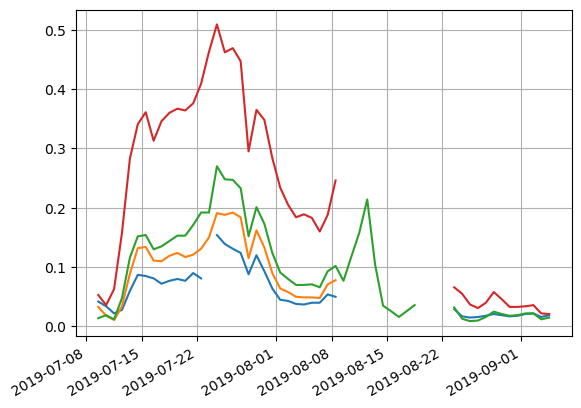

In [5]:
pygui(false)
fig=figure()
plot(t1_daily,temp1_daily)
plot(t2_daily,temp2_daily)
plot(t3_daily,temp3_daily)
plot(t5_daily,temp5_daily)
fig[:autofmt_xdate](bottom=0.2,rotation=30,ha="right") 
grid(true)

### Hourly (corrected)

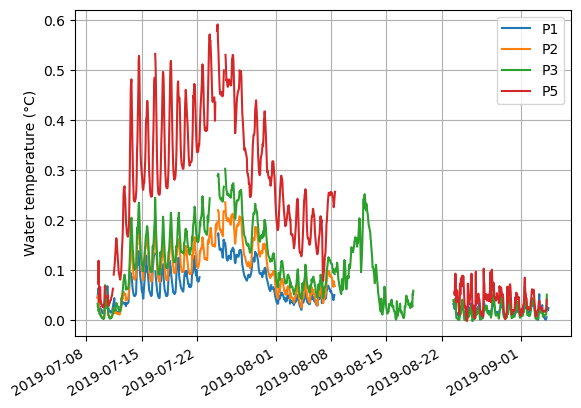

In [6]:
pygui(false)
fig=figure()
plot(t1_hour,temp1_hour,label="P1")
plot(t2_hour,temp2_hour,label="P2")
plot(t3_hour,temp3_hour,label="P3")
plot(t5_hour,temp5_hour,label="P5")
#xlim(DateTime(2019,7,9),DateTime(2019,7,13))
fig[:autofmt_xdate](bottom=0.2,rotation=30,ha="right") 
grid(true)
ylabel("Water temperature (°C)")
legend()

# Temperature decrease along the canal 

**For Hours scale:
Index 41 = 11th July 0:00
Index 722 = 8th august 9:00 
[41:722] --> periode where lake is drainaing with 4 sensors available**

**For Daily scale
Index 3 (day 3 = 10th July) is still not nice because daily mean temperature does not reflect a full "drainage mode".
From day 4 and onward it is Ok**



**Distance from P5 (m)**

- P5= 0
- P2 = 151.3
- P3 = 253.7
- P2 = 312.6
- P1 = 464.4

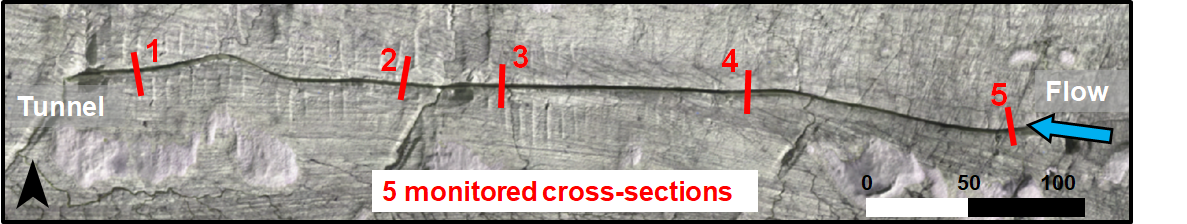


# Plot the decrease in temperature along canal and fit an exponential law

$ T(x) = a * e^{-xk} $ 

**We fit a and k in our data**  with  $ a = T_0 = T_{P5} $

$1/k$ is called the "e folding length"

## Hourly mean decrease

In [7]:
d = [0, 253.7, 312.6, 464.4]  #P5,P3,P2,P1
k = [];
error_k = []
t0 = []
t_k = []

pygui(false)
tstart = findfirst(x -> x == DateTime(2019,7,12,12), t3_hour) #set the start of k and thus Nu calculation
for i in tstart :722  #numbers of hours, 27 is 10 July at 15h. 724 is the end. 77 the 12th at 12:00 (when the 
            #temperature decrease start to be coherent (decrease with distance)
    
    #below chose if wou want daily mean decrease or hourly mean
    local temp = vcat(temp5_hour[i],temp3_hour[i],temp2_hour[i],temp1_hour[i])
    local d = [0, 253.7, 312.6, 464.4] #since d is modified within the loop (regarding naN association), we redefine it
    local purge = []
    
    for i in 1:length(temp)
        if isnan(temp[i])
            purge = push!(purge, i)  
        end
    end
    deleteat!(temp, purge)
    deleteat!(d, purge)
    #At this stage temp can be a [Float64], a single element or a 2 element array. Let's allow only the fit from 3 
                #to 4 temperature measurements
    
    if length(temp) > 2
        
     @. model(x, p) = p[1]*exp(-x*p[2]) # p[1]==a, p[2]==k
    para_weights = [0.4, 0.005] # 
    fit = curve_fit(model, d, temp,para_weights)
    err = margin_error(fit, 1-0.95);
    distance =  range(0, 2000, step=0.1)
     
    push!(t0, fit.param[1])
    push!(k, fit.param[2]) 
    push!(error_k, err[2])
    push!(t_k, t3_hour[i])  #t3_hour is the longest time series, the most complete. we take it to avoid the lost
                            #in other time series due to NaN or nothing values
        
    end
        
end


#savefig(path_plots*"temp_decrease.png")

## Hourly visualization - Figure 7.

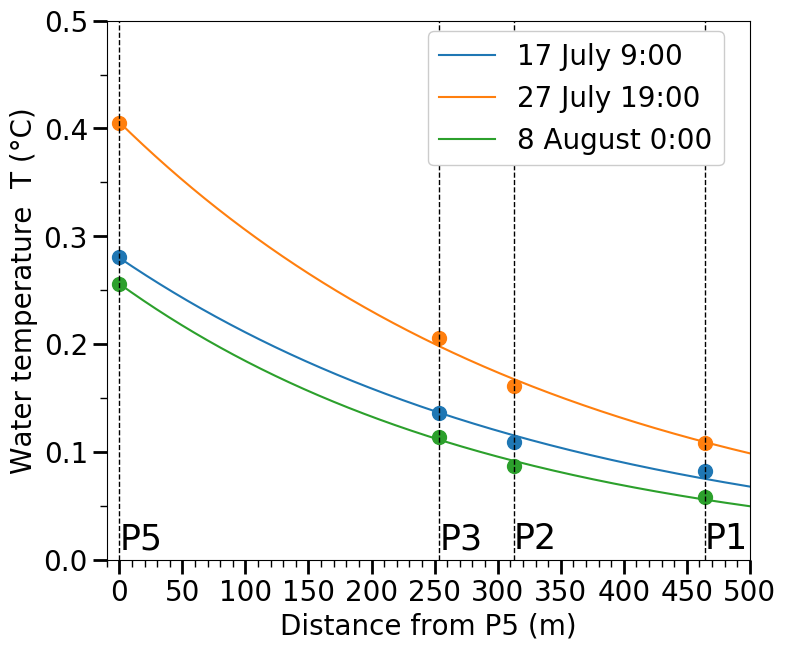

In [8]:
set_temp = [194,444,713]  #the index of the three example we want to plot


pygui(false)

fig= figure(figsize=(8.3,7))

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
font0 = Dict(
        "font.size" => 25,
        "axes.labelsize" => 20,
        "xtick.labelsize" => 20,
        "ytick.labelsize" => 20,
        "legend.fontsize" => 20,
)
merge!(rcParams, font0)

#Temperature profiles
for i in set_temp  #numbers of hours, 27 is 10 July at 15h. 722 is the end
    
    #below chose if wou want daily mean decrease or hourly mean
    temp = vcat(temp5_hour[i],temp3_hour[i],temp2_hour[i],temp1_hour[i])
    #temp = vcat(temp5_daily[i],temp3_daily[i],temp2_daily[i],temp1_daily[i])
    
    if !any(isnan, temp)
 
     @. model(x, p) = p[1]*exp(-x*p[2]) # p[1]==a, p[2]==k
    para_weights = [0.4, 0.005] # 
    fit = curve_fit(model, d, temp,para_weights)
    err = stderror(fit);
    distance =  range(0, 2000, step=0.1)   
        day=Dates.day(t1_hour[i])
        month = Dates.monthname(t1_hour[i];locale="english")
        hour = Dates.hour(t1_hour[i])        
        
    plot(distance, model(distance, coef(fit)), label = "$day $month $hour:00")
    #text(200,0.1,"$(1/fit.param[2])")
    xlim(-10,500)
    ylim(0,0.5)
    ylabel("Temperature (°C)")
    xlabel("Distance from P5 (m)")
    scatter(d,temp, s=100)
    
    end
        
end

ax = gca()
#Major and minor ticks


Mx = matplotlib.ticker.MultipleLocator(50) # Define interval of major ticks
#f = matplotlib[:ticker][:FormatStrFormatter]("%1.2f") # Define format of tick labels
ax.xaxis.set_major_locator(Mx) # Set interval of major ticks
#ax[:xaxis][:set_major_formatter](f) # Set format of tick labels
mx = matplotlib.ticker.MultipleLocator(10) # Define interval of minor ticks
ax.xaxis.set_minor_locator(mx) # Set interval of minor ticks
ax.xaxis.set_tick_params(which="major",length=10,width=2)
ax.xaxis.set_tick_params(which="minor",length=5,width=1)

My = matplotlib[:ticker][:MultipleLocator](0.1) # Define interval of major ticks
ax.yaxis.set_major_locator(My) # Set interval of major ticks
my = matplotlib.ticker.MultipleLocator(0.05) # Define interval of minor ticks
ax.yaxis.set_minor_locator(my) # Set interval of minor ticks
ax.yaxis.set_tick_params(which="major",length=10,width=2)
ax.yaxis.set_tick_params(which="minor",length=5,width=1)

#vlines
#distance from DEM, origin at P5
d=[464.4,312.6,253.7,151.3,0];
#P5
axvline(x=d[5], linestyle="--", linewidth=1,color="black")
text(d[5],0.01,"P5")
#P3
axvline(x=d[3],linestyle="--", linewidth=1,color="black")
text(d[3],0.01,"P3")
#P2
axvline(x=d[2], linestyle="--", linewidth=1,color="black")
text(d[2],0.01,"P2")
#P1
axvline(x=d[1], linestyle="--", linewidth=1,color="black")
text(d[1],0.01,"P1")

legend(framealpha=1,bbox_to_anchor=[0.5,0.98],loc=2,borderaxespad=0)
ylabel("Water temperature  T (°C)")
#title("Temperature decrease along channel")
savefig(path_plots*"fig07.pdf")
#savefig(path_plots*"temp_decrease_along_channel.png")


#IF ERRORS: re run the box right above

In [9]:
#back to default ploting parameters:
matplotlib.rcdefaults()

### `1/k` time series (hourly)


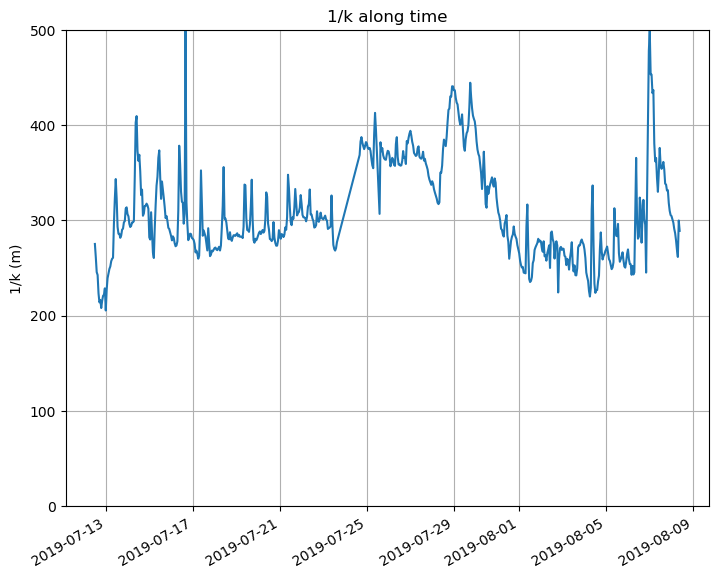

PyObject Text(23.999999999999993, 0.5, '1/k (m)')

In [10]:
pygui(false)
fig = figure()
fig= figure(figsize=(8.3,7))
plot(t_k,1 ./k)
fig[:autofmt_xdate](bottom=0.2,rotation=30,ha="right")
ylim(0,500)
grid(true)
title("1/k along time")
ylabel("1/k (m)")

### Distribution of `1/k` (hourly)

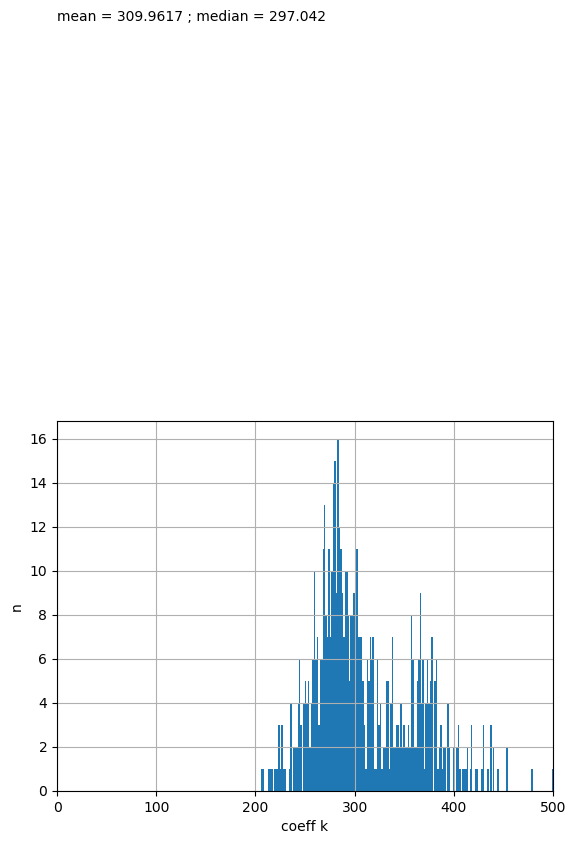

In [11]:
pygui(false)
nbins = 200
h = plt.hist(1 ./ k,nbins) # Histogram
xlabel("coeff k")
ylabel("n")
xlim(0,500)
text(0.005,35,"mean = $(round(mean(1 ./k), digits = 4)) ; median = $(round(median(1 ./k), digits = 4))")
grid(true)
#savefig(path_plots*"k_coeff.png")

## Daily mean decrease

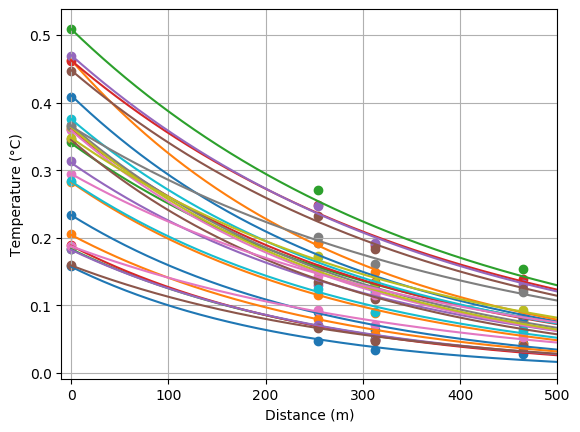

In [12]:
d = [0, 253.7, 312.6, 464.4]  #P5,P3,P2,P1
k_daily = [];
error_k_daily = []
t0_daily = []
t_k_daily = []

pygui(false)
for i in 4:30  #end = 30
    
    local d = [0, 253.7, 312.6, 464.4]
    local temp = vcat(temp5_daily[i],temp3_daily[i],temp2_daily[i],temp1_daily[i])
    local purge = []
    
    for i in 1:length(temp)
        if isnan(temp[i])
            purge = i #Attention! It remove only the first indice. by chance it works as only daily P1 time series
                                #has NaN. But this is different for hourly 
        end
    end
    deleteat!(temp, purge)
    deleteat!(d, purge)
    
 
    @. model(x, p) = p[1]*exp(-x*p[2]) # p[1]==a, p[2]==b
    para_weights = [0.4, 0.005] # 
    fit = curve_fit(model, d, temp,para_weights)
    err = stderror(fit);
    distance =  range(0, 500, step=0.1)   
    plot(distance, model(distance, coef(fit)))
    xlim(-10,500)
    ylabel("Temperature (°C)")
    xlabel("Distance (m)")
    scatter(d,temp)
    grid(true)    
    push!(t0_daily, fit.param[1])
    push!(k_daily, fit.param[2]) 
    push!(error_k_daily, err[2])
    push!(t_k_daily,t1_daily[i])
        
        
end

## `k_daily` time series 

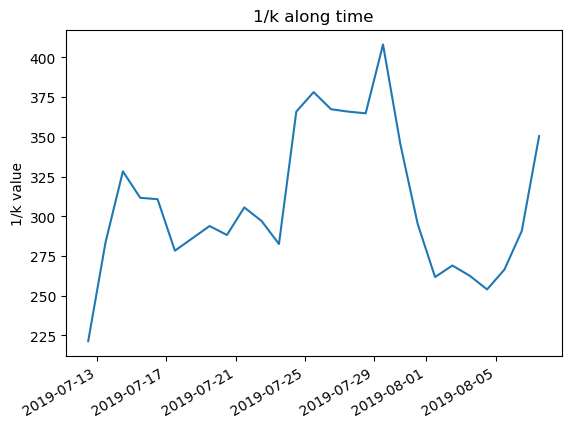

PyObject Text(24.000000000000007, 0.5, '1/k value')

In [13]:
k_daily_m = 1 ./ k_daily
fig = figure()
plot(t_k_daily,k_daily_m)
fig[:autofmt_xdate](bottom=0.2,rotation=30,ha="right")
title("1/k along time")
ylabel("1/k value")

## `k_daily` distribution 

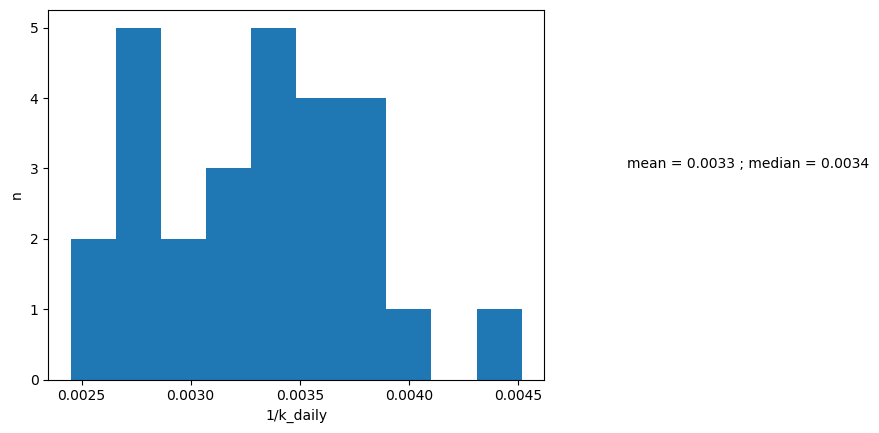

PyObject Text(0.005, 3, 'mean = 0.0033 ; median = 0.0034')

In [14]:
pygui(false)
nbins = 10
h = plt.hist(k_daily,nbins) # Histogram
xlabel("1/k_daily")
ylabel("n")

text(0.005,3,"mean = $(round(mean(k_daily), digits = 4)) ; median = $(round(median(k_daily), digits = 4))")

## Discharge VS 1/k_hourly 

In [15]:
#Discharge
d, head = readdlm(path_products*"discharge_channel_hourly_std_deviation.csv" , ',', header=true);
qp3_hourly = d[:,2];
err_qp3_hourly = d[:,3];
t3_hour = [DateTime(dd, "yyyy-mm-ddTH:M:S") for dd in d[:,1]];


In [16]:
#to do : match the two different time series of k_hourly and qp3_hourly with findfirst() to get
#the same size(they have the same scale  but they don't have the same start)

#And then scatter(qp3_daily[...], k_daily[...])

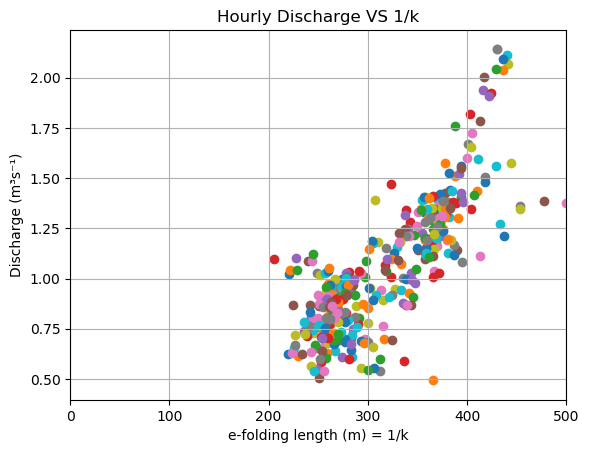

In [17]:
for i in 10:length(t_k)   #t_k[10] is 11 July 00:00, before the temperature pattern is not well etablished...
    
    local t = findfirst(x -> x == t_k[i], t3_hour)
    scatter(1/k[i],qp3_hourly[t])   
    
    
end
xlim(0,500)
title("Hourly Discharge VS 1/k")
xlabel("e-folding length (m) = 1/k")
ylabel("Discharge (m³s⁻¹)")
grid(true)

# Exponential decrease according to Isenko 2005 (equation 20)

$$ T(x) = T_\infty + (T_0 - T_\infty)\exp{(-\frac{x}{x_0})} $$

with:
$$T_\infty = T_m + \frac{g\rho R \theta}{B}$$ 

$$x_0 = \frac{C_w\rho_w R}{B}$$

$T_\infty$ is the equilibrium temperature ($R$ hydraulic radius, $\theta$ hydraulic slope and $B = 2.64\,10^3 Jm^{-3}K^{-1}$ for turbulent water at 0°C) 

and $x_0$ is the e-floding length ($1/k$ previously)

In [18]:
pygui(false)

d = [0, 253.7, 312.6, 464.4]  #P5,P3,P2,P1
distance =  range(0, 500, step=0.1)
tinf = []
x0 = [];
error_x0 = []
t_temp = []

for i in 74:700  #numbers of hours, 27 is 10 July at 15h BUT relevant temperature profile only after 56 or 57 = 11 july 16h
                 # Moreover before 74 there is LinearAlgebra error... because of the no-exponential profile I think
                  
    temp = vcat(temp5_hour[i],temp3_hour[i],temp2_hour[i],temp1_hour[i]) 
    
    if !any(isnan, temp)
        
    T0 = temp5_hour[i]
    @. model(x, p) = p[1] + (T0 - p[1])exp(-x/p[2]) # p[1]== T_infini, p[2]==x0
    para_weights = [0.05, 200]
    fit = curve_fit(model, d, temp,para_weights)
    sigma = stderror(fit)
    push!(tinf, fit.param[1])
    push!(x0, fit.param[2]) 
    push!(error_x0, sigma[2])
    push!(t_temp, t1_hour[i])
    end
end

    

### For visualization: Hourly 

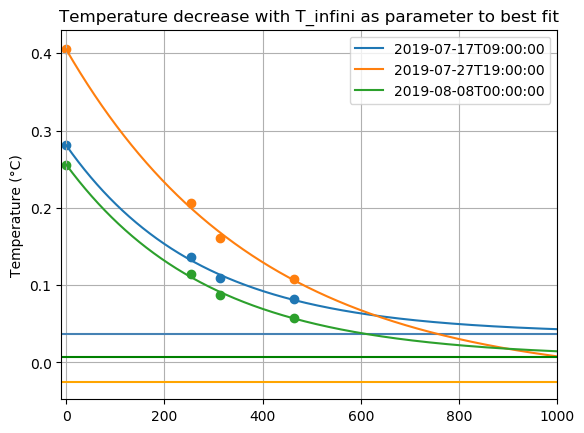

In [19]:
;   #we don't run this cell in Products_run.jpynb, because it says " c nor defined" for unknown reasons
pygui(false)

d = [0, 253.7, 312.6, 464.4]  #P5,P3,P2,P1
distance =  range(0, 1000, step=0.1)
color_hline = ["steelblue","orange","green"] #otherwise this is always blue and does not automatically match plotline color
c = 1
for i in set_temp  #see above
    
    #numbers of hours, 27 is 10 July at 15h BUT relevant temperature profile only after 56 or 57 = 11 july 16h
                 # Moreover before 56 there is LinearAlgebra error... because of the no-exponential profile I think
    
    temp = vcat(temp5_hour[i],temp3_hour[i],temp2_hour[i],temp1_hour[i]) 
    if !any(isnan, temp)
   
    T0 = temp5_hour[i]
    @. model(x, p) = p[1] + (T0 - p[1])exp(-x/p[2]) # p[1]== T_infini, p[2]==x0
    para_weights = [0.05, 200]
    fit = curve_fit(model, d, temp,para_weights)
    sigma = stderror(fit)
    
    t = t1_hour[i]
    plot(distance, model(distance, coef(fit)), label = "$t")
    axhline(y=fit.param[1],color = color_hline[c]) #t_infini hline
        c = c + 1
    scatter(d,temp)

    end
end
xlim(-10,1000)
ylabel("Temperature (°C)")
grid(true)
legend()
title("Temperature decrease with T_infini as parameter to best fit")    
savefig(path_plots*"temp_decrease_tinf=param.png")

### For visualization: Daily

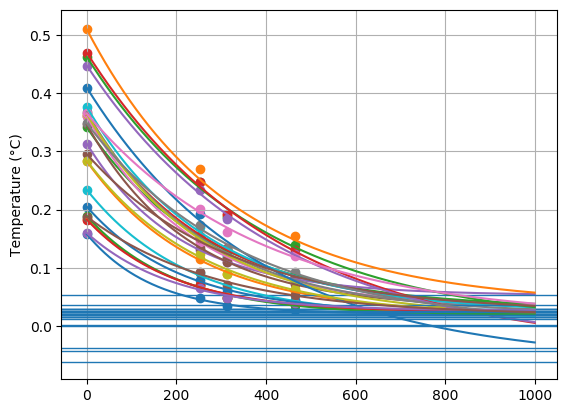

In [20]:
pygui(false)

d = [0, 253.7, 312.6, 464.4]  #P5,P3,P2,P1
distance =  range(0, 1000, step=0.1)

for i in 4:30  #numbers of hours, 27 is 10 July at 15h BUT relevant temperature profile only after 56 or 57 = 11 july 16h
                 # Moreover before 56 there is LinearAlgebra error... because of the no-exponential profile I think
    
    temp = vcat(temp5_daily[i],temp3_daily[i],temp2_daily[i],temp1_daily[i])
    
    if !any(isnan, temp)
   
    T0 = temp5_daily[i]
    @. model(x, p) = p[1] + (T0 - p[1])exp(-x/p[2]) # p[1]== T_infini, p[2]==x0
    para_weights = [0.05, 200]
    fit = curve_fit(model, d, temp,para_weights)
    sigma = stderror(fit)
    
    plot(distance, model(distance, coef(fit)), label = "$(t1_daily[i])")
    axhline(y=fit.param[1],linewidth=1) #t_infini hline
    scatter(d,temp)

    end
end
ylabel("Temperature (°C)")
grid(true)
#legend()

## `x0` and `T_infini` distribution over time

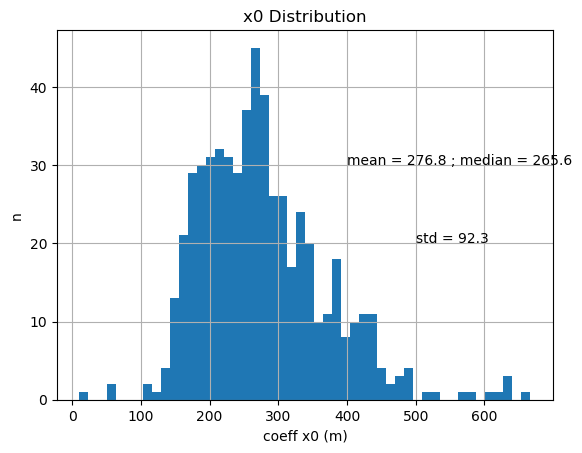

PyObject Text(500, 20, 'std = 92.3')

In [21]:
pygui(false)
nbins = 50
h = plt.hist(x0,nbins) # Histogram
xlabel("coeff x0 (m)")
ylabel("n")
grid(true)
title("x0 Distribution")
text(400,30,"mean = $(round(mean(x0), digits = 1)) ; median = $(round(median(x0), digits = 1))")
text(500,20,"std = $(round(std(x0), digits = 1))")
#savefig(path_plots*"k_coeff.png")

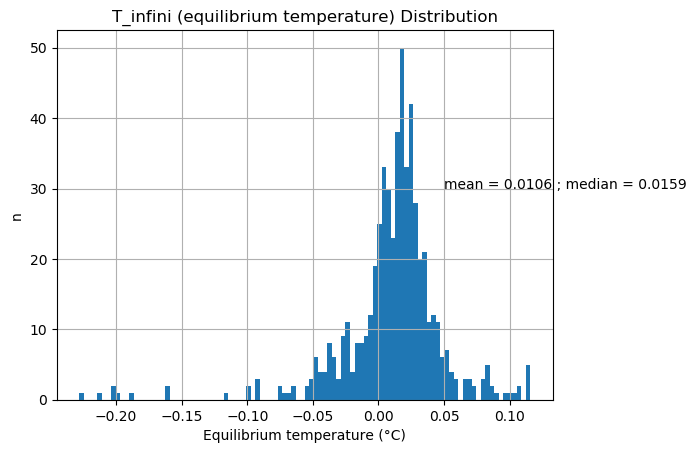

PyObject Text(0.05, 30, 'mean = 0.0106 ; median = 0.0159')

In [22]:
pygui(false)
nbins = 100
h = plt.hist(tinf,nbins) # Histogram
xlabel("Equilibrium temperature (°C)")
ylabel("n")
grid(true)
title("T_infini (equilibrium temperature) Distribution")
text(0.05,30,"mean = $(round(mean(tinf), digits = 4)) ; median = $(round(median(tinf), digits = 4))")
#savefig(path_plots*"k_coeff.png")

# $x_0$ VS discharge (`qp3_hourly`)

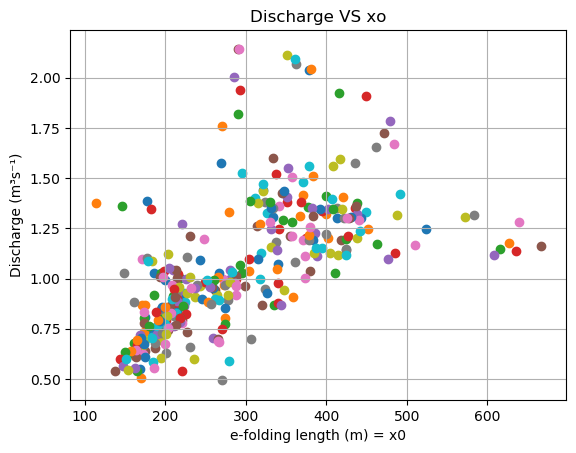

In [23]:
for i in 10:length(t_temp)   #t_k[10] is 11 July 00:00, before the temperature pattern is not well etablished...
    
    local t = findfirst(x -> x == t_temp[i], t3_hour)
    scatter(x0[i],qp3_hourly[t])   
    
    
end

title("Discharge VS xo")
xlabel("e-folding length (m) = x0")
ylabel("Discharge (m³s⁻¹)")
grid(true)

# Hydraulic radius $R$ obtained from $x_0$ equation

To recall:

$$x_0 = \frac{C_w\rho_w R}{B}$$

In [24]:
#To compare
#import R derived from friction factor calculation between P5 and P3

R_53 = [0.222 ± 0.028, 0.21 ± 0.028, 0.223 ± 0.028, 
    0.274 ± 0.027, 0.351 ± 0.025, 0.428 ± 0.025, 0.353 ± 0.025, 0.346 ± 0.025]
t_R_53 = [DateTime(2019,7,10,15,35,25), DateTime(2019,7,11,9,27,5), DateTime(2019,7,11,12,51,40),
    DateTime(2019,7,16,14,12,10), DateTime(2019,7,25,8,44,25), DateTime(2019,7,30,14,47,15),
DateTime(2019,7,30,18,34,5), DateTime(2019,7,31,9,39,30)];

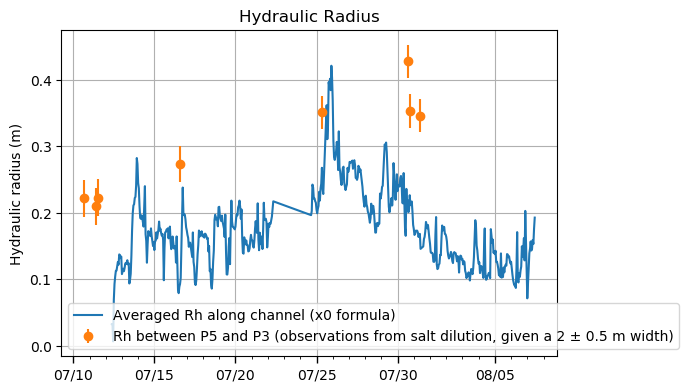

In [25]:
Cw = 4.18*10^3 #specific heat of water
rho = 1000 #rho water
B = 2.64*10^3

R = @. x0*B/(Cw*rho);

fig = figure()
plot(t_temp, R, label = "Averaged Rh along channel (x0 formula)")
ylabel("Hydraulic radius (m)")

grid(true)
errorbar(t_R_53,mean.(R_53), yerr = std.(R_53), linestyle = "", marker = "o", label = "Rh between P5 and P3 (observations from salt dilution, given a 2 ± 0.5 m width)")
legend()
title("Hydraulic Radius")

majorformatter = matplotlib.dates.DateFormatter("%m/%d")
majorlocator   = matplotlib.dates.DayLocator(bymonthday=(5,10,15,20,25,30))
minorlocator   = matplotlib.dates.DayLocator(interval=1)
ax = gca()
ax.xaxis.set_major_formatter(majorformatter)
ax.xaxis.set_major_locator(majorlocator)
ax.xaxis.set_minor_locator(minorlocator)
ax.xaxis.set_tick_params(which="major",length=5,width=1,labelsize=10)
fig[:autofmt_xdate](bottom=0.2,rotation=0,ha="center")

# Nusselt number from temperature decrease: Spatial-cooling-rate (SCR) method

Recall: we already calculated $Nu$ from heat flux (i.e from melt rate: temporal approach).
Here we calculate $Nu$ from a spatial approach, i.e from the temperature decrease along channel.
For that we eprime the e-folding length as an function of $Nu$. 
Bellow a smiling Mauro hidden by his lunch-time maths:


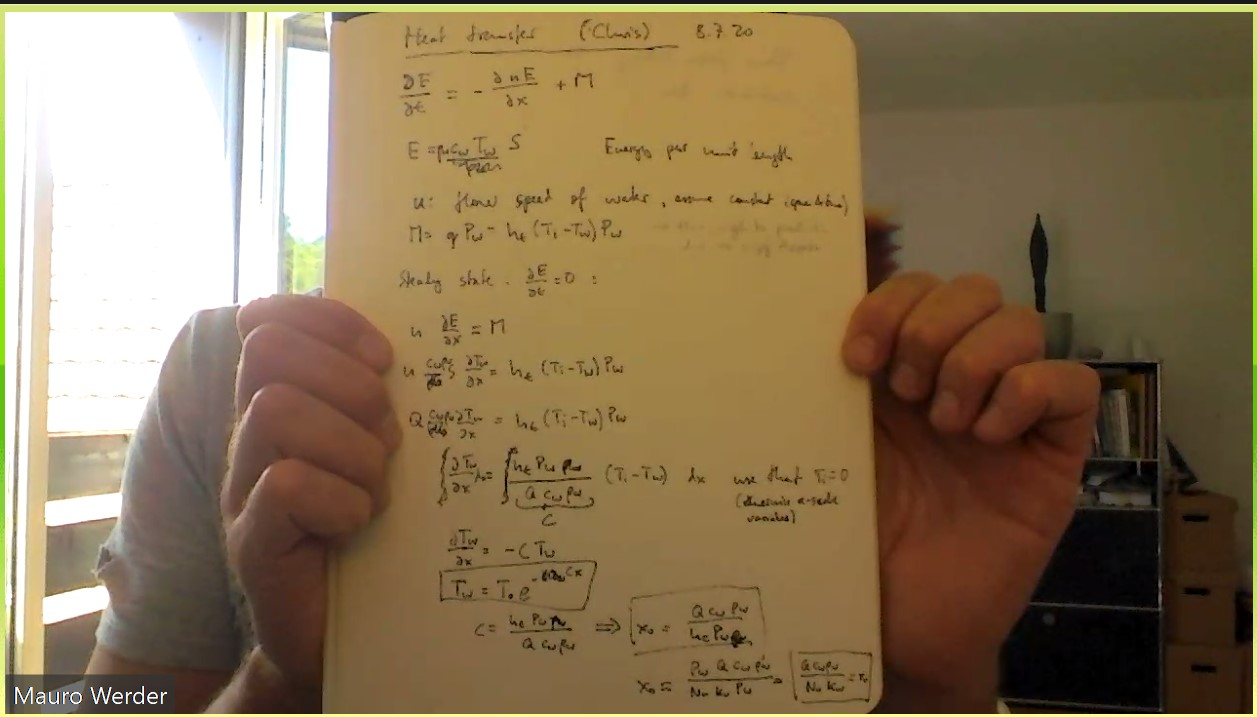

So we have at the end:


$$x_0 = \frac{Q C_w\rho_w \lambda}{Nu K_w P_w}$$

and then

$$Nu = \frac{Q C_w\rho_w \lambda}{x_0 K_w P_w}$$

where $P_w$ is the wetted perimeter and $\lambda$ the Nu scale length

In [26]:
# We match hourly times series of x0 and qp3 for 10 July and 8 august (end of decrease temperature measurement)

#qp3
ti = findfirst(x -> x == DateTime(2019,7,10) , t3_hour)
tf = findfirst(x -> x == DateTime(2019,8,8) , t3_hour);

In [27]:
a = []  #a will be the ratio of discharge over e-folding length
t_nu = []

for i in 1:length(t_k) #t_k is the shortest time series
    
    j = findfirst(x -> x == t_k[i], t3_hour)
    if j !== nothing
        if err_qp3_hourly[j] !== NaN #NaN does not work with ±
            
            #attention: e = 1/k !
            local x = (qp3_hourly[j] ± err_qp3_hourly[j]) / (1 / (k[i] ± error_k[i]))    #std error on discharge and k (from model fit)
       
        else
            local x = NaN
        end
        push!(a, x)
        push!(t_nu, t3_hour[j])   #in fact t_nu = t_k I guess 
    end
    
end

#Nu
kw = 0.57
w = 2 ± 0.5
h = 0.5 ± 0.1
Pw = w + 2h  #Pw rougly estimated for the while channel length 
dh = 4*h*w/Pw  #hydraulic diameter

nu_x0_dh = a*Cw*rho*dh/(kw*Pw);  #in our study lambda = dh
nu_x0_Pw = a*Cw*rho/kw; #if lamda is taken as the weeted perimeter in Walder and Costa 1996


### Filling the gap with daily discharge and daily `x_0`

In [41]:
d, head = readdlm(path_products*"discharge_channel_full_daily.csv" , ',', header=true);
qp3_daily = d[:,2];
t3_daily = [DateTime(dd, "yyyy-mm-ddTH:M:S") for dd in d[:,1]];

In [43]:
a = []  #a will be the ratio of discharge over e-folding length
t_nu_daily = []

for i in 1:length(t_k_daily) #t_k is the shortest time series
    
    j = findfirst(x -> x == t_k_daily[i], t3_daily)
    if j !== nothing
            x = (qp3_daily[j]) / (1 /(k_daily[i] ± error_k_daily[i]))    #std error on daily discharge not available 
       
        else
            x = NaN
        end
        push!(a, x)
        push!(t_nu_daily, t3_daily[j])    
end

#Nu
kw = 0.57

#lambda=dh
nu_x0_daily_dh = a*Cw*rho*dh/(kw*Pw);
#lambda = Pw (not used in this study)
nu_x0_daily_Pw = a*Cw*rho/kw;

In [44]:
t3_daily

58-element Array{DateTime,1}:
 2019-07-09T12:00:00
 2019-07-10T12:00:00
 2019-07-11T12:00:00
 2019-07-12T12:00:00
 2019-07-13T12:00:00
 2019-07-14T12:00:00
 2019-07-15T12:00:00
 2019-07-16T12:00:00
 2019-07-17T12:00:00
 2019-07-18T12:00:00
 2019-07-19T12:00:00
 2019-07-20T12:00:00
 2019-07-21T12:00:00
 ⋮
 2019-08-24T12:00:00
 2019-08-25T12:00:00
 2019-08-26T12:00:00
 2019-08-27T12:00:00
 2019-08-28T12:00:00
 2019-08-29T12:00:00
 2019-08-30T12:00:00
 2019-08-31T12:00:00
 2019-09-01T12:00:00
 2019-09-02T12:00:00
 2019-09-03T12:00:00
 2019-09-04T12:00:00

In [45]:
##discharge
#plot(t3_hour,qp3_hourly)
#plot(t3_daily,qp3_daily)
##Temperature at P3
#plot(t3_hour,temp3_hour)
#plot(t3_daily,temp3_daily)

## Plot Nusselt number  `Nu_x0` using SCR method

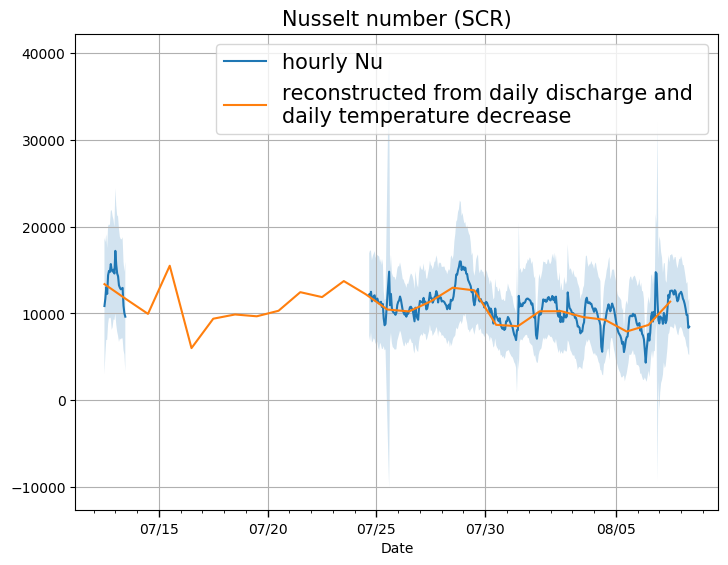

In [46]:
#hourly
fig= figure(figsize=(8.3,7))
plot(t_nu,mean.(nu_x0_dh),label="hourly Nu")
fill_between(t_nu, mean.(nu_x0_dh) .- std.(nu_x0_dh), mean.(nu_x0_dh) .+ std.(nu_x0_dh), alpha=0.2)
#daily
plot(t_nu_daily,mean.(nu_x0_daily_dh),label="reconstructed from daily discharge and 
daily temperature decrease")
grid(true)
xlabel("Date")
legend(fontsize = 15)
title("Nusselt number (SCR)", fontsize = 15)
#ylim(0,60000)
majorformatter = matplotlib.dates.DateFormatter("%m/%d")
majorlocator   = matplotlib.dates.DayLocator(bymonthday=(5,10,15,20,25,30))
minorlocator   = matplotlib.dates.DayLocator(interval=1)
ax = gca()
ax.xaxis.set_major_formatter(majorformatter)
ax.xaxis.set_major_locator(majorlocator)
ax.xaxis.set_minor_locator(minorlocator)
ax.xaxis.set_tick_params(which="major",length=5,width=1,labelsize=10)
fig[:autofmt_xdate](bottom=0.2,rotation=0,ha="center")


### To store `Nu_x0_dh` and `Nu_x0_daily_dh` in a CSV file
**Nu length scale is the hydraulic diameter (named `dh` here) in our study** 

In [51]:
using DataFrames
using CSV

#lambda = dh
#hourly
df=DataFrame(Date_Time = t_nu, Nusselt = round.(mean.(nu_x0_dh), digits=3), 
    std_dev =  round.(std.(nu_x0_dh),digits=3))
CSV.write(path_products*"Nusselt_SCR_hourly.csv",df ; dateformat = "yyyy-mm-ddTH:M:S");
#daily
df=DataFrame(Date_Time = t_nu_daily, Nu = round.(mean.(nu_x0_daily_dh),digits=3))  #std deviation does not take uncertainties on daily discharge...
CSV.write(path_products*"Nusselt_SCR_daily.csv",df ; dateformat = "yyyy-mm-ddTH:M:S");


#if lambda = Pw was chosen
#df=DataFrame(Date_Time = t_nu, Nu = mean.(nu_x0_Pw), nu_x0_Pw_err =  std.(nu_x0_Pw))
#CSV.write(path_products*"Nu_x0_Pw.csv",df ; dateformat = "yyyy-mm-ddTH:M:S");

#df=DataFrame(Date_Time = t_nu_daily, Nu = mean.(nu_x0_daily_Pw))  
#CSV.write(path_products*"Nu_x0_daily_Pw.csv",df ; dateformat = "yyyy-mm-ddTH:M:S");

In [52]:
nu_x0_daily_dh

27-element Array{Particles{Float64,2000},1}:
 13400.0 ± 1800.0
 11600.0 ± 1300.0
  9950.0 ± 1100.0
 15500.0 ± 1700.0
  6000.0 ± 710.0
  9390.0 ± 1000.0
  9880.0 ± 1100.0
  9670.0 ± 1000.0
 10300.0 ± 1100.0
 12400.0 ± 1500.0
 11900.0 ± 1500.0
 13700.0 ± 1500.0
 12200.0 ± 1700.0
     ⋮
 11400.0 ± 1300.0
 13000.0 ± 1600.0
 12600.0 ± 1400.0
  8680.0 ± 980.0
  8530.0 ± 980.0
 10200.0 ± 1200.0
 10300.0 ± 1200.0
  9570.0 ± 1200.0
  9270.0 ± 1100.0
  7920.0 ± 1000.0
  8670.0 ± 1200.0
 11400.0 ± 1300.0